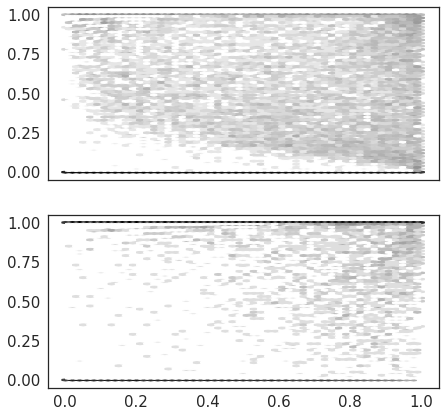

In [58]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot overlaps among HSP sets as heatmap
# with similarities calculated as Jaccard index

date = '20180611'

run_plot_seg_agreement = True
run_plot_segcons_heatmap = False
run_plot_repcons_heatmap = False
run_plot_scorecons_heatmap = False

save_figures = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'ox_bioinf'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['emission', 'replicate']
segmentations = ['cmm18', 'ecs18', 'ecs10']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

data_root = os.path.join(fhgfs_base, 'sciddo', 'deep')
isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   
    
def collect_hsp_coverage(rootfolder):
    collector = col.Counter()
    for root, dirs, datafiles in os.walk(rootfolder):
        if root.endswith('data_dump'):
            for df in datafiles:
                if df.endswith('.bed') and df.startswith('deep_hg38_'):
                    data = pd.read_csv(os.path.join(root, df), sep='\t', header=0)
                    parts = df.split('.')[0].split('_')
                    seg, c1, c2, score = parts[2], parts[3], parts[5], parts[6].split('-')[1]
                    collector[(c1 + '_vs_' + c2, score, seg)] += int((data['chromEnd'] - data['chromStart']).sum())
    return collector
    

def collect_hsp_overlaps(paths):
    
    collector = col.Counter()
    for path in paths:
        for root, dirs, tables in os.walk(path):
            if tables:
                for t in tables:
                    if t.endswith('.tsv'):
                        file_id1, file_id2 = t.split('.')[0].split('-ovl-')
                        seg1, comp1, score1 = file_id1.split('-')
                        seg2, comp2, score2 = file_id2.split('-')
                        
                        tsv_path = os.path.join(root, t)
                        try:
                            ovl = pd.read_csv(tsv_path, sep='\t', header=None)
                        except EmptyDataError:
                            print('File empty: {}'.format(tsv_path))
                            shared = 0
                        else:
                            shared = int(ovl[ovl.columns[-1]].sum())
                        collector[((comp1, score1, seg1), (comp2, score2, seg2))] += shared
    return collector


def get_all_hsp(seg, score, comp):
    fpath = os.path.join(data_root, seg, 'data_dump', 'deep_hg38_{}_{}_hsp-{}.bed'.format(seg, comp, score))
    df = pd.read_csv(fpath, sep='\t', header=0)
    assert df.shape[0] > 0, 'No HSPs loaded from file: {}'.format(fpath)
    header = ['chrom'] + df.columns[1:].tolist()
    df = df[['name', 'chromStart', 'chromEnd']].copy()
    return df, header


def collect_hsp_agreement(paths, cache_file):
    
    total_hsp = col.Counter()
    header = None
    split_a = ['A_name', 'A_chromStart', 'A_chromEnd', 'overlap']
    split_b = ['B_name', 'B_chromStart', 'B_chromEnd', 'overlap']
    
    subset_columns = ['name', 'length', 'coverage', 'pct_rank_len', 'pct_cov',
                      'chromStart', 'chromEnd', 'group', 'segment', 'scoring']
        
    with pd.HDFStore(cache_file, 'w') as cache:
        for path in paths:
            for tsv in os.listdir(path):
                if not tsv.endswith('.tsv'):
                    continue
                fpath = os.path.join(path, tsv)
                
                seg1, seg2 = tsv.split('.')[0].split('-ovl-')
                seg1, comp1, score1 = seg1.split('-')
                seg2, comp2, score2 = seg2.split('-')

                hsp_a, header = get_all_hsp(seg1, score1, comp1)
                hsp_a.columns = ['name', 'chromStart', 'chromEnd']
                header_a = ['A_' + h for h in header]
                header_b = ['B_' + h for h in header]
                header = header_a + header_b + ['overlap']
                
                hsp_b, _ = get_all_hsp(seg2, score2, comp2)
                hsp_b.columns = ['name', 'chromStart', 'chromEnd']

                df = pd.read_csv(fpath, sep='\t', header=None, names=header)
                
                # handle direction A to B
                shared_a = df[split_a].copy()
                tmp = shared_a.groupby(['A_name', 'A_chromStart', 'A_chromEnd'], as_index=False)['overlap'].sum()
                tmp.columns = ['name', 'chromStart', 'chromEnd', 'coverage']
                tmp['pct_cov'] = tmp['coverage'] / (tmp['chromEnd'] - tmp['chromStart'])
                
                hsp_a = hsp_a.merge(tmp, how='outer', on=['name', 'chromStart', 'chromEnd'], suffixes=('', ''))
                hsp_a.fillna(0, inplace=True)
                hsp_a['group'] = 'A'
                hsp_a['length'] = hsp_a['chromEnd'] - hsp_a['chromStart']
                hsp_a['pct_rank_len'] = hsp_a['length'].rank(pct=True)
                hsp_a['segment'] = seg1
                hsp_a['scoring'] = score1
                                
                # handle direction B to A
                shared_b = df[split_b].copy()
                tmp = shared_b.groupby(['B_name', 'B_chromStart', 'B_chromEnd'], as_index=False)['overlap'].sum()
                tmp.columns = ['name', 'chromStart', 'chromEnd', 'coverage']
                tmp['pct_cov'] = tmp['coverage'] / (tmp['chromEnd'] - tmp['chromStart'])
                
                hsp_b = hsp_b.merge(tmp, how='outer', on=['name', 'chromStart', 'chromEnd'], suffixes=('', ''))
                hsp_b.fillna(0, inplace=True)
                hsp_b['group'] = 'B'
                hsp_b['length'] = hsp_b['chromEnd'] - hsp_b['chromStart']
                hsp_b['pct_rank_len'] = hsp_b['length'].rank(pct=True)
                hsp_b['segment'] = seg2
                hsp_b['scoring'] = score2
                
                df = pd.concat([hsp_a, hsp_b], axis=0, ignore_index=False)
                df = df[subset_columns].copy()
                                
                cov_max = df['pct_cov'].max()
                assert cov_max < 1 or np.isclose(cov_max, 1, atol=1e-6), \
                    'Pct. cov off: {}'.format(df['pct_cov'].max())
                                
                cache_path = os.path.join(seg1, score1, comp1, seg2, score2, comp2)
                cache.put(cache_path, df, format='table')               
    return cache_file


def plot_agreement_scatter(dataset, fkey):
    """
    """
    
    fig, (ax_1, ax_2) = plt.subplots(figsize=fig_sizes['two_col']['square'],
                                     nrows=2, ncols=1, sharex=True, sharey=True,
                                     gridspec_kw={'height_ratios': [1, 1]})
    
    markersize = 20
    alpha = 0.7
    a_marker = 'o'
    a_color = 'dimgrey'
    b_marker = 'o'
    b_color = 'black'
    
    
    sub_a = dataset.loc[dataset['group'] == 'A', :].copy()
    sub_b = dataset.loc[dataset['group'] == 'B', :].copy()
        
#     ax_1.scatter(sub_a['pct_rank_len'], sub_a['pct_cov'],
#                  s=markersize, alpha=alpha,
#                  marker=a_marker, color=a_color)
        
#     ax_2.scatter(sub_b['pct_rank_len'], sub_b['pct_cov'],
#                  s=markersize, alpha=alpha,
#                  marker=b_marker, color=b_color)

    ax_1.hexbin(sub_a['pct_rank_len'], sub_a['pct_cov'],
                cmap='binary', bins='log', gridsize=(50, 50))
    
    ax_2.hexbin(sub_b['pct_rank_len'], sub_b['pct_cov'],
                cmap='binary', bins='log', gridsize=(50, 50))
    
    return fig, []


def build_jaccard_dist_matrix(totals, shared, selectors, add_score=False, add_segment=False):
    jaccard = []
    labels = []
    for (file_a, file_b), ovl in shared.items():
        if all([(s in file_a) and (s in file_b) for s in selectors]):
            a_total = totals[file_a]
            b_total = totals[file_b]
            j = np.round(ovl / (a_total + b_total - ovl), 3)                    
            a_label = ' '.join(file_a[0].split('_'))
            b_label = ' '.join(file_b[0].split('_'))
            if add_score:
                a_label += ' ' + file_a[1]
                b_label += ' ' + file_b[1]
            if add_segment:
                a_label += ' ' + file_a[2]
                b_label += ' ' + file_b[2]
            jaccard.append((a_label, b_label, j))
            jaccard.append((b_label, a_label, j))
            labels.extend([a_label, b_label])
    labels = sorted(set(labels))
    dim = len(labels)
    df = pd.DataFrame(np.zeros((dim, dim), dtype=np.float32),
                      index=labels, columns=labels)
    for r, c, j in jaccard:
        df.loc[r, c] = j
    
    return df    


def create_clustermap(data, col_annot=None, annot_label=None, legend_bb=None):
    """
    """
    exart = []
    if col_annot is not None:
        col_colors = []
        short_labels = []
        for c in data.columns:
            l, a = c.rsplit(' ', 1)
            col_colors.append(col_annot[a.strip()])
            short_labels.append(l.strip())
        data.columns = short_labels
        data.index = short_labels
    else:
        col_colors = None
    cm = sns.clustermap(data, method='average', metric='euclidean',
                        row_cluster=True, col_cluster=True, figsize=fig_sizes['two_col']['square'],
                        vmin=0, vmax=1, center=0.5, cmap="Greys", annot=False,
                        linewidths=0.1, linecolor='whitesmoke', col_colors=col_colors,
                        row_colors=col_colors,
                        cbar_kws={'label': 'Jaccard', 'ticks': [0., 0.3, 0.7, 1.]},
                        xticklabels=data.columns, yticklabels=data.columns)
    
    cm.cax.set_ylabel('Jaccard', fontsize=12)
    cbar_yax = cm.cax.get_yaxis()
    cbar_yax.set_ticklabels(list(map(str, [0., 0.3, 0.7, 1.])), fontsize=10)
        
    if col_annot is not None:
        # Add tissue/color legend
        annot_handles = []
        for k, color in col_annot.items():
            label = annot_label[k]
            annot_handles.append(mpatches.Patch(color=color, label=label))
        
        leg_annot = plt.legend(handles=annot_handles, title=annot_label['title'],
                               markerscale=2, fontsize=16, loc=3, bbox_to_anchor=legend_bb,
                               prop={'size':18}, ncol=len(col_annot), frameon=True)
        exart.append(leg_annot)
    
    fig_title = cm.fig.suptitle('Figure X', fontsize=16)
    exart.append(fig_title)
    return cm, exart
    
            
def plot_repcons_heatmap():
    isect_files = [os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_ident'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_diff_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_repcons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_coverage(hsp_files_folder)
        shared = collect_region_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']
    fig_size = (20, 20)
    for seg in ['cmm18', 'ecs18', 'ecs10']:
        for mat in ['emission', 'replicate']:
            sim_mat = build_jaccard_dist_matrix(totals, shared, [seg, mat])
            title = 'HSP consistency across replicates: {} segmentation / {} scoring'.format(seg, mat)
            fig, exart = create_clustermap(sim_mat, title, fig_size)
            if save_figures:
                outname = '{}_fig_X_hsp_repcons_{}_{}'.format(date, seg, mat)
                out_svg = os.path.join(fig_collect, outname + '.svg')
                fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
                out_pdf = os.path.join(fig_collect, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                out_png = os.path.join(fig_collect, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0

def plot_scorecons_heatmap():
    isect_files = [os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_ident'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_ident_diff'),
                   os.path.join(fhgfs_base, 'bedtools/deep/hsp_isect/ident_diff_diff')]
    cache_file = os.path.join(cache_dir, '{}_plot_scorecons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_data(hsp_files_folder)
        shared = collect_region_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']
    col_colors = {'R': 'blue', 'E': 'lightskyblue'}
    annot_labels = {'R': 'Replicate', 'E': 'Emission', 'title': 'Scoring matrix'}
    leg_bb = (20, 1.3)
    fig_size = (20, 20)
    for seg in ['cmm18', 'ecs18', 'ecs10']:
        sim_mat = build_jaccard_dist_matrix(totals, shared, [seg], True, False)
        title = 'HSP consistency across scoring matrices: {} segmentation'.format(seg)
        fig, exart = create_clustermap(sim_mat, title, fig_size, col_colors, annot_labels, leg_bb)
        if save_figures:
            outname = '{}_fig_X_hsp_scorecons_{}'.format(date, seg)
            out_svg = os.path.join(fig_collect, outname + '.svg')
            fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
            out_pdf = os.path.join(fig_collect, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            out_png = os.path.join(fig_collect, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0


def plot_segmentation_agreement():
    isect_files = [os.path.join(isect_root, 'hsp_isect/diff_ident_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_segagree_scatter.h5'.format(date))
    if not os.path.isfile(cache_file) or os.stat(cache_file).st_size < 5e6:
        _ = collect_hsp_agreement(isect_files, cache_file)
        
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for s1, s2 in itt.product(['cmm18', 'ecs18', 'ecs10'], repeat=2):
            if s1 == s2:
                continue
            for score in ['emission', 'replicate']:
                load_keys = [k for k in cached_keys if all(x in k for x in [s1, s2, score])]
                if not load_keys:
                    continue
                plot_data = []
                for k in load_keys:
                    data = hdf[k]
                    plot_data.append(data)
                plot_data = pd.concat(plot_data, axis=0, ignore_index=False)
                fig, exart = plot_agreement_scatter(plot_data, 'Figure X')
                
                if save_figures:
                    outname = '{}_fig_X_hsp_scorecons_{}'.format(date, seg)
                    
                    out_pdf = os.path.join(fig_collect, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    out_png = os.path.join(fig_collect, outname + '.png')
                    fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolutions[res])
                break
            break
    return


def plot_segcons_heatmap():
    isect_files = [os.path.join(isect_root, 'hsp_isect/ident_ident_ident'),
                   os.path.join(isect_root, 'hsp_isect/diff_ident_ident'),
                   os.path.join(isect_root, 'hsp_isect/ident_diff_ident')]
    cache_file = os.path.join(cache_dir, '{}_plot_segcons_heatmap.pck'.format(date))
    if not os.path.isfile(cache_file):
        totals = collect_hsp_coverage(data_root)
        shared = collect_hsp_overlaps(isect_files)
        with open(cache_file, 'wb') as cache:
            pck.dump({'totals': totals, 'shared': shared}, cache)
    else:
        with open(cache_file, 'rb') as cache:
            dump = pck.load(cache)
            totals = dump['totals']
            shared = dump['shared']

    col_colors = {'C8': 'blue', 'E8': 'lightskyblue', 'E0': 'steelblue'}
    annot_labels = {'C8': 'ChromHMM 18', 'E8': 'EpiCSeg 18',
                    'E0': 'EpiCSeg 10', 'title': 'Segmentation'}
    leg_bb = (16, 1.3)
    for scoring in ['emission', 'replicate']:
        sim_mat = build_jaccard_dist_matrix(totals, shared, [scoring], False, True)
       
        fig, exart = create_clustermap(sim_mat, None, None, leg_bb)
        if save_figures:
            outname = 'fig_X_hsp_segcons_{}'.format(scoring)
            out_svg = os.path.join(fig_collect, outname + '.svg')
            fig.savefig(out_svg, bbox_inches='tight', extra_artists=exart)
            out_pdf = os.path.join(fig_collect, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            out_png = os.path.join(fig_collect, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=300)
    return 0

if run_plot_seg_agreement:
    plot_segmentation_agreement()


if run_plot_segcons_heatmap:
    plot_segcons_heatmap()

if run_plot_repcons_heatmap:
    plot_repcons_heatmap()
    
if run_plot_scorecons_heatmap:
    plot_scorecons_heatmap()
    
